This is the Bayesian optimisation workflow envlopped in a class.

In [1]:
import numpy as np
seed = 95
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor as GPR

from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from scipy.optimize import minimize


Important inputs:

- Measurements: real_X, real_Y :np.ndarray

These are experimental measurements, or our initial data. 
Note if these are one-dimensional, we need to reshape it into (-1, 1) before feeding into gaussian process regression.

- Expected noise level: noise_level: float

The (expected) standard deviation of the observables. 
According to the 3sigma rule, this value indicates 67% probablity that the observable would be within +/- noise_level from the expecation value (mean) of the observable. 

- Kernel format for GP

This will be pre-guessed by user and submit in a hyperparameter dictionary.

- An initial guess for the starting point for prediction

x0. This can be user specified, or auto generated by the mean of all data.

In [29]:
#user inputs and pre-define hyperparameters

noise_level = 0.1 #the expected standard deviation of experimental measurement

#hyperparameters for rbf
rbf_hp = {
    'length_scale': 1,
    'length_scale_bounds' : (1e-2, 1e2),
    'amp' : 1,
    'const' : 0
}

kernel = rbf_hp['amp']*RBF(length_scale = rbf_hp['length_scale'], length_scale_bounds = rbf_hp['length_scale_bounds']) + rbf_hp['const']

#hyperparameters and kernel dictionary
gpr_hp_dict = {
    'alpha' : noise_level,
    'kernel' : kernel,
    'random_state' : 1
}

#X's to predict by GPR
#see the X = linspace part in the next cell 


measured X: [ 0.83910682 -4.53024646 -9.5995576  -2.62807685 -2.27931653  4.5273988
 -6.34622451 -5.60515155 -0.44465197 -5.45700649  1.74733768]
measured Y: [10.82706122 12.15251677 17.31283162  9.65877902  9.29189967 11.87500577
 12.66755388 12.63727191  9.43673742 12.55066149 11.62389877]


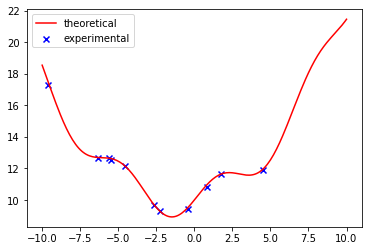

In [30]:
#generate initial (imaginary) data

def std_model(X:np.ndarray)->np.ndarray:
    """
    This is the standard model without noise
    """
#     Y = 0.5*X**2 + 0.3*X + 0.1 #This is a pre-defined real physical model for us to compare with the prediction results
    Y = 0.1*X**2 + np.sin(X) + 0.2*X + 10 # an arbitrary function, as long as it has a minimal
    return Y

def exp_model(X:np.ndarray, noise_level = 0.1):
    #noise_level is the standard deviation, 67% of the data will be within pm 1 from the centre y data
    Y = std_model(X)
    noise = np.random.normal(scale = noise_level, size = Y.shape)
    real_Y = Y + noise
    return real_Y

#generate the initial X
X = np.linspace(-10, 10, 201) #Generate 201 initial points from -10 to 10
#This is X_to_predict in the class later
Y = std_model(X)
real_X = np.random.uniform(-10, 10, 11) # this is the perturbated series.
real_Y = exp_model(real_X, noise_level = noise_level)


#plot initial dataset
fig, ax = plt.subplots()
ax.plot(X, Y, color = 'red', label = 'theoretical')
ax.scatter(real_X, real_Y, color = 'blue', marker = 'x', label = 'experimental')
ax.legend()


#print measurements data
print(f"measured X: {real_X}")
print(f"measured Y: {real_Y}")

In [31]:
def convert_dim(X):
    """
    The dimension of X must be 2.
    If X is a 1D array, reshape it to 2.
    Otherwise raise error.
    
    The first index is the number of sample.
    The second index is the number of dimension.
    There should not be any more dimension.
    """
    if not isinstance(X, np.ndarray):
        if isinstance(X, list):
            X = convert_dim(np.array(X))
        elif isinstance(X, (int, float, complex)):
            X = convert_dim(np.array([X]))
            
    
    if len(X.shape) == 1:
        return X.reshape(-1, 1)
    elif len(X.shape) == 2:
        return X
    else:
        raise ValueError(f"The shape of X: {len(X.shape)}, is larger than 2.")


def convert_type_y(Y):
    if not isinstance(Y, np.ndarray):
        if isinstance(Y, list):
            Y = np.array(Y)
        elif isinstance(Y, (int, float, complex)):
            Y = np.array([Y])
        
    
    return Y

In [32]:
# test_X_1D = np.random.rand(2) #two samples, one dimension
# convert_dim(test_X_1D) #expected to return a 2D array with two samples (shape = (2, 1))
# print(test_X_1D)
# print(convert_dim(test_X_1D))
# print(convert_dim(test_X_1D).shape)

# test_X_2D = np.random.rand(4, 2) #four samples, two dimensional
# convert_dim(test_X_2D)
# print(convert_dim(test_X_2D))
# print(convert_dim(test_X_2D).shape) #expected to be a 2D array with four samples (shape = (4, 2))

# test_X_3D = np.random.rand(2, 3, 4) # five samples, three dimnesional -> expected to get an error message
# print(test_X_3D)
# print(convert_dim(test_X_3D))

In [33]:
class BayesOpt:
    
    def __init__(self):
        self.data_X = [] # initialise the data container
        self.data_Y = []
        self.gpr_log = {}
        
    
    def load_data(self, X:np.ndarray, Y:np.ndarray):
        """
        Load real measurement data
        """
        #get the right shape, 2d array
        reshp_X = convert_dim(X)
        
        self.data_X = reshp_X
        self.data_Y = convert_type_y(Y)
        
#         print(self.data_X)
#         print(self.data_Y)
    
    def do_gpr(self, gpr_hp:dict):
        """
        run gaussian progress regression.
        The hyperparameters are pre-defined by users in gpr_hp.
        The model will auto refine itself based on the data fed into it.
        """
        kernel = gpr_hp['kernel']
        random_state = gpr_hp['random_state']
        alpha = gpr_hp['alpha'] #the noise level
        
        #check if data has been properly loaded. Abort if not.
        if len(self.data_X) != 0:
            gpr = GPR(kernel = kernel, alpha = alpha, random_state = random_state).fit(self.data_X, self.data_Y)
            self.gpr_log['gpr'] = gpr
        
        else:
            raise ValueError("No data has been loaded. Please load initial measurement data.")
        
        #results
        new_kernel = gpr.kernel_ #return kernel after training
        gpr_score = gpr.score(self.data_X, self.data_Y) #return fitting score
        
        self.gpr_log['opt_kernel']  = new_kernel
        self.gpr_log['score'] = gpr_score
        
        print(f"gpr log: {self.gpr_log}")
        print("Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs")
    
    def gpr_predict(self, X_to_predict, return_std = True, get_plot = True):
        
        self.reshp_X_to_predict = convert_dim(X_to_predict) #the X series to predict, needs to be reshaped before feeding into gpr
        
        self.X_to_pred_for_plot = X_to_predict #the X series to plot
        
        self.y_pred_mean, self.y_pred_std = self.gpr_log['gpr'].predict(self.reshp_X_to_predict, return_std = True) #prediction
        
        if get_plot:
            self.plot_gpr_results() #optional

        
    def plot_gpr_results(self, aq_func = None):
        """
        This step is the one to give you the transparent fillings behind the curve.
        Also the iconic styles seen in BO related papers.
        However, if you try to run the workflow again, this confidence interval part could change.
        There are many random factors involved there...
        """
        fig, ax = plt.subplots()
#         ax.plot(self.reshp_X_to_predict, Y, color = 'red', ls = '--', label = 'theoretical')
        ax.errorbar(self.data_X, self.data_Y, yerr = noise_level, color = 'black', ls = 'None', marker = '.', label = 'experimental')
        #yerr is the noise_level used above
        ax.plot(self.X_to_pred_for_plot, self.y_pred_mean, color = 'tab:orange', label = 'predicted mean')
        ax.fill_between(self.X_to_pred_for_plot, self.y_pred_mean-self.y_pred_std*1.96, self.y_pred_mean+self.y_pred_std*1.96, alpha = 0.5, color = 'tab:orange', label = '95% confidence level')
        #1.96 on std is to plot 95% confidence interval
        
        if aq_func is not None:
            ax.plot(self.X_to_pred_for_plot, self.aq_func_Y, color = 'blue', ls = '--', label = 'aq_func')
            
        ax.legend()
        
        
    def aq_func(self, x0, option = 'ucb', get_aq_plot = True, **kwargs):
        """
        choose which aq_func to use, default ucb.
        Other three tb explored...
        x0 is the initial guess for the prediction to start with.
        """
        
#         kwargs['ucb_beta'] = 1.96
        if option == 'ucb':
            ucb_beta = kwargs['ucb_beta'] if 'ucb_beta' in kwargs else 1.96
            print("UCB starts...")
            res = minimize(self.aq_func_ucb, x0 = x0, args = (ucb_beta, self.gpr_log['gpr']), tol = 1e-2) #this is one step of BO
            self.min_success = res.success
            self.next_x = res.x
            
            self.aq_func_Y = self.aq_func_ucb(self.X_to_pred_for_plot, ucb_beta, self.gpr_log['gpr'])
            if get_aq_plot:
                self.plot_gpr_results(aq_func = 'ucb')

        print(f"success?: {self.min_success}")
        
        if self.min_success is True:
            print(f"Recommended next x to go: {self.next_x}")
        else:
            print("Failed to predict. Please check results status:")
            print(res)

    
    def aq_func_ucb(self, x, ucb_beta, gpr):
        mean, std = gpr.predict(convert_dim(x), return_std = True)
        return  mean - ucb_beta*std
    
    def add_new_data(self, new_x, new_y):
        """
        Users can add new data to training set using this function
        """
        crt_data_x = self.data_X
        crt_data_y = self.data_Y
        
        reshp_new_x = convert_dim(new_x)
        retyp_new_y = convert_type_y(new_y)
        
        #print(reshp_new_x, retyp_new_y)
        
        #concact two arrays together
        concat_data_x = np.concatenate((crt_data_x, reshp_new_x), axis = 0)
        concat_data_y = np.concatenate((crt_data_y, retyp_new_y), axis = 0)
        
        self.data_X = concat_data_x
        self.data_Y = concat_data_y
        
        #print(self.data_X, self.data_Y)
    

C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


gpr log: {'gpr': GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=1) + 0**2,
                         random_state=1), 'opt_kernel': 11.5**2 * RBF(length_scale=3.74) + 0.00318**2, 'score': 0.9970013531853029}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [-1.2609268]


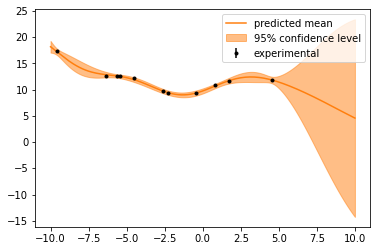

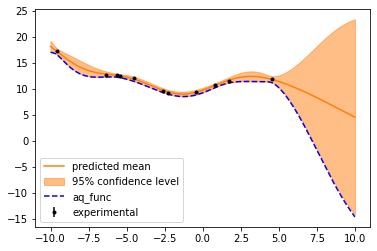

In [34]:
#testblock
#print("real_X, real_Y")
#print(real_X, real_Y)

x0 = 0.5

bo = BayesOpt()
#print("load_data, after dimension conversion:")

#load initial data
bo.load_data(real_X, real_Y)

#first round of gpr
bo.do_gpr(gpr_hp_dict)
bo.gpr_predict(X)
#check the GPR results make sense or not. If yes, please continue with aqusition functions
#Otherwise, modify the gpr_hp_dict inputs

#do prediction for initial guess x0
bo.aq_func(x0, ucb_beta = 2)



gpr log: {'gpr': GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=1) + 0**2,
                         random_state=1), 'opt_kernel': 11.4**2 * RBF(length_scale=3.63) + 0.00318**2, 'score': 0.9971443339670064}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [-1.40923529]


C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


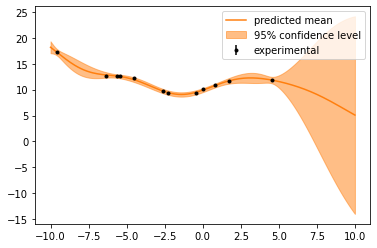

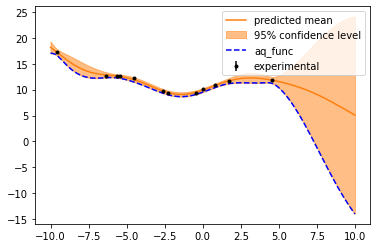

In [35]:
#add new dataset to the prior knowledgebase
#make sure the index in the new_x series match with the new_y series
#For example, np.array([new_x_0, new_x_1, ...]), np.array([new_y_0, new_y_1, ...]) correspond to (new_x_0, new_y_0), (new_x_1, new_y_1), etc.
#here, new_x and new_y can either be numbers or list or array

new_x = np.array([0.004])
new_y = exp_model(new_x, noise_level = noise_level)

#the array form
# new_x = np.array([-5, 2.5]) 
# new_y = np.array([9, 5])
bo.add_new_data(new_x, new_y)

#run gpr + aq_func step again, see what has changed
bo.do_gpr(gpr_hp_dict)
bo.gpr_predict(X)
bo.aq_func(x0, ucb_beta = 1.96)
#It is expected to see more experimental data points in the second figure.
#The model has also been refined. (check gpr_log parameters)

In [36]:
len(bo.data_X) #after only running the cell above, you can see the new datapoint has been added to the prior dataset

12

In [37]:
#get the next x from previous results, and feed into the new dataset
def forward(previous_next_x:float, get_plots = True):
    
    new_x = np.array([previous_next_x]) if isinstance(previous_next_x, (float, int)) else previous_next_x #the next x predicted by the previous cycle of bo
    new_y = exp_model(new_x, noise_level = noise_level) #exp_model is global function

    bo.add_new_data(new_x, new_y) #bo is also a global instance

    #run gpr + aq_func step again, see what has changed
    bo.do_gpr(gpr_hp_dict)
    bo.gpr_predict(X, get_plot = get_plots) #X is a global variable for plot
    
    x0 = previous_next_x
    bo.aq_func(x0, get_aq_plot = get_plots, ucb_beta = 1.96)
    
    return bo.next_x
    

gpr log: {'gpr': GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=1) + 0**2,
                         random_state=1), 'opt_kernel': 11.4**2 * RBF(length_scale=3.6) + 0.00318**2, 'score': 0.9974019242196984}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [-1.45247148]


C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


array([-1.45247148])

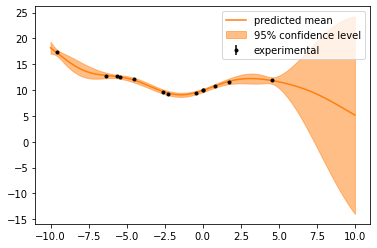

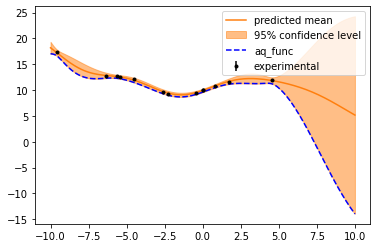

In [38]:
forward(-0.006)

In [39]:
def auto_forward_until_convg(initial_x0, n_max = 1000, tol = 1e-4):
    """
    start the bo cycle by user speciifed initial guess.
    automatically feed the next x into the dataset and repeat the bo cycle until two x below the tolerance
    """
    
    n = 0
    x0 = initial_x0
    while n < n_max:
        
        next_x = forward(x0, get_plots = False)
        if not bo.min_success:
            print(f"Convergence failed at the {n}th step. \n The final x before crash is: {x0}\n")
            return x0 #failed to converge in bo
        elif abs(next_x - x0) <= tol:
            print(f"Convergence successful with {n} steps. \n The optimal x is: {next_x}\n")
            print("The convergenced status is: ")
            bo.plot_gpr_results(aq_func = 'ucb')
            return next_x # converged
        else:
            x0 = next_x
            n+=1
    print(f"Max iteration steps reached. Fail to converge.\n The final x before crash is: {x0}\n")
    return x0
            
        
        

gpr log: {'gpr': GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=1) + 0**2,
                         random_state=1), 'opt_kernel': 11.4**2 * RBF(length_scale=3.55) + 0.00318**2, 'score': 0.9971326936960382}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [-1.50962673]
gpr log: {'gpr': GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=1) + 0**2,
                         random_state=1), 'opt_kernel': 11.4**2 * RBF(length_scale=3.59) + 0.00318**2, 'score': 0.9969943353236678}
Look out for warning message. If says convergence failed, please modify the gpr_hp_dict inputs
UCB starts...
success?: True
Recommended next x to go: [-1.49778603]
gpr log: {'gpr': GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=1) + 0**2,
                         random_state=1), 'opt_kernel': 11.4**2 * RBF(length_scale=3.55) + 0.00318**2, 'score': 0.997327506

C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


array([-1.49778603])

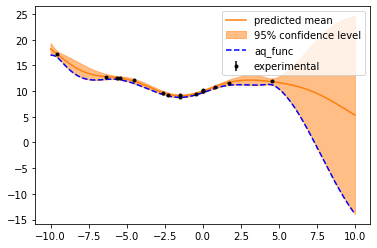

In [40]:
x0 = 0.01
auto_forward_until_convg(x0)